# DenseNet121 + SE Block

In [10]:
# DenseNet121 + SE Block Integration with Three Augmentation Strategies

import torch
import torch.nn as nn
from torchvision.models import densenet121, DenseNet121_Weights
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
from itertools import product
from IPython.display import display
from torch.optim.lr_scheduler import StepLR

In [11]:
# Append dataset module path
sys.path.append(os.path.abspath(".."))
from dataset import create_dataloaders

In [12]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=8):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.BatchNorm1d(channel // reduction),
            nn.SiLU(),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


In [13]:
def densenet121_se(num_classes, reduction=8):
    base_model = densenet121(weights=DenseNet121_Weights.DEFAULT)
    
    features = base_model.features
    classifier = base_model.classifier

    class DenseNetSE(nn.Module):
        def __init__(self):
            super(DenseNetSE, self).__init__()
            self.stem = nn.Sequential(*list(features.children())[:4])  # conv0 + norm0 + relu0 + pool0
            self.block1 = features.denseblock1
            self.trans1 = features.transition1
            self.block2 = features.denseblock2
            self.trans2 = features.transition2
            self.block3 = features.denseblock3
            self.trans3 = features.transition3
            self.block4 = features.denseblock4
            self.norm5 = features.norm5

            self.se1 = SEBlock(256, reduction=reduction)
            self.se2 = SEBlock(512, reduction=reduction)
            self.se3 = SEBlock(1024, reduction=reduction)
            self.se4 = SEBlock(1024, reduction=reduction)

            self.classifier = nn.Linear(1024, num_classes)

        def forward(self, x):
            x = self.stem(x)
            x = self.block1(x)
            x = self.se1(x)
            x = self.trans1(x)
            x = self.block2(x)
            x = self.se2(x)
            x = self.trans2(x)
            x = self.block3(x)
            x = self.se3(x)
            x = self.trans3(x)
            x = self.block4(x)
            x = self.se4(x)
            x = self.norm5(x)
            x = nn.functional.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
            x = self.classifier(x)
            return x

    return DenseNetSE()


In [14]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [15]:
# Accuracy eval function
def evaluate_accuracy(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


=== Running strategy with SE: minimal ===
Epoch 1/10 | Loss: 100.0128 | Train Acc: 0.8833 | Val Acc: 0.9367 | Val Loss: 15.7505
Epoch 2/10 | Loss: 22.0029 | Train Acc: 0.9739 | Val Acc: 0.9379 | Val Loss: 15.4803
Epoch 3/10 | Loss: 13.0693 | Train Acc: 0.9851 | Val Acc: 0.9437 | Val Loss: 14.1911
Epoch 4/10 | Loss: 7.7888 | Train Acc: 0.9900 | Val Acc: 0.9542 | Val Loss: 11.1838
Epoch 5/10 | Loss: 6.7304 | Train Acc: 0.9914 | Val Acc: 0.9567 | Val Loss: 11.0619
Epoch 6/10 | Loss: 3.4646 | Train Acc: 0.9962 | Val Acc: 0.9550 | Val Loss: 11.3008
Epoch 7/10 | Loss: 2.5741 | Train Acc: 0.9979 | Val Acc: 0.9637 | Val Loss: 9.6754
Epoch 8/10 | Loss: 1.3790 | Train Acc: 0.9990 | Val Acc: 0.9617 | Val Loss: 9.9854
Epoch 9/10 | Loss: 1.9281 | Train Acc: 0.9975 | Val Acc: 0.9567 | Val Loss: 10.0523
Epoch 10/10 | Loss: 0.9992 | Train Acc: 0.9992 | Val Acc: 0.9646 | Val Loss: 9.1696
Plotting training history...


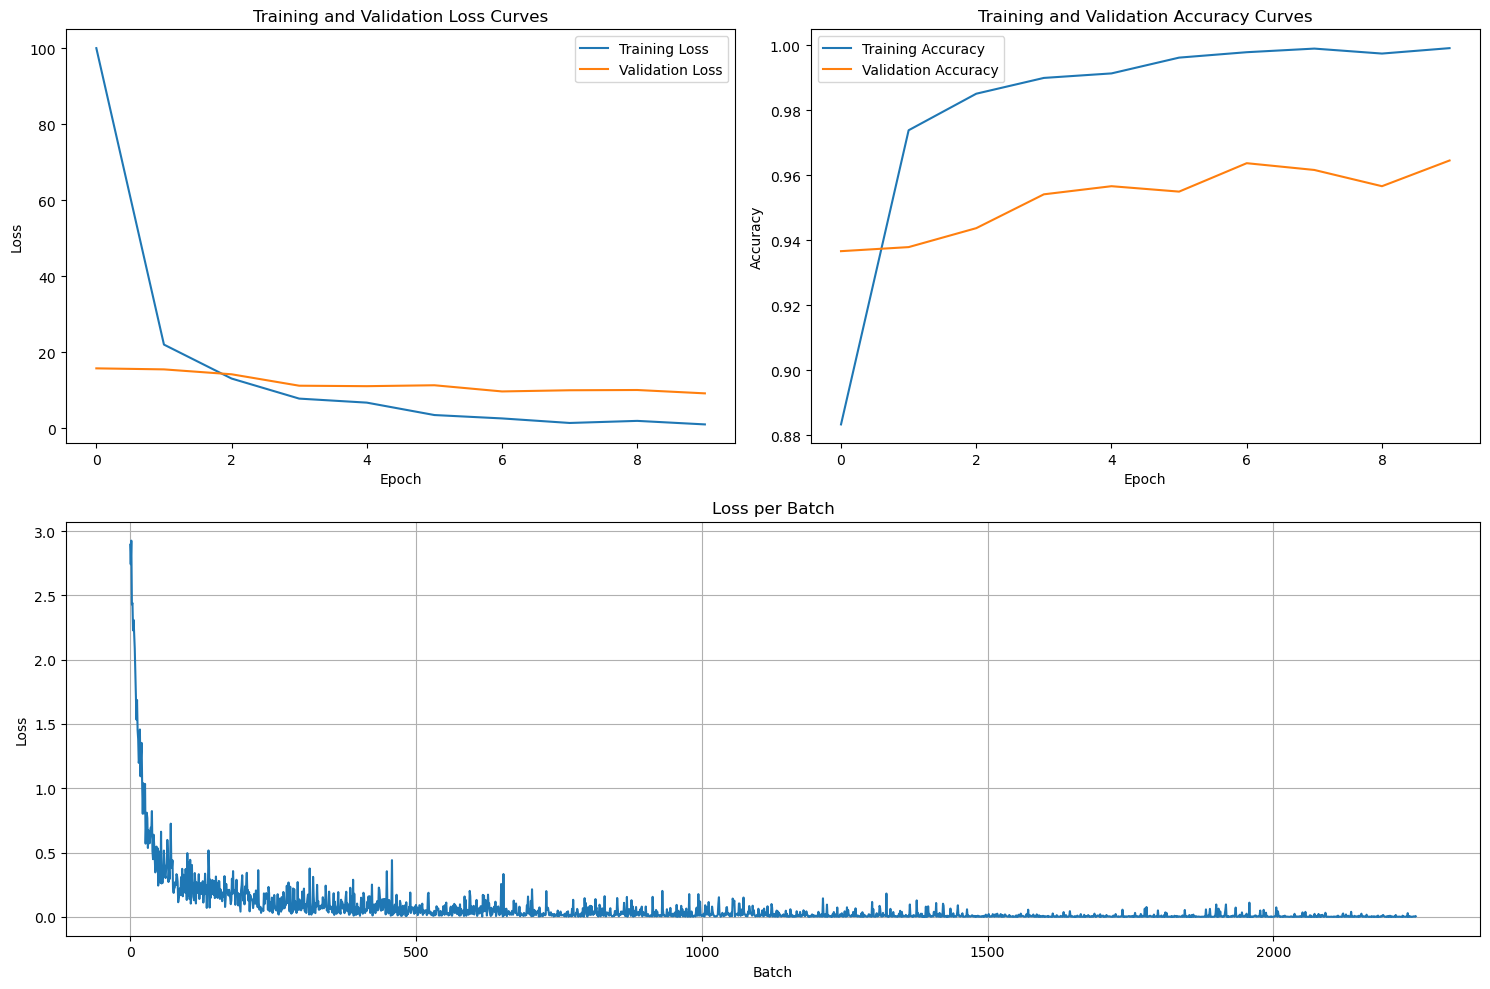

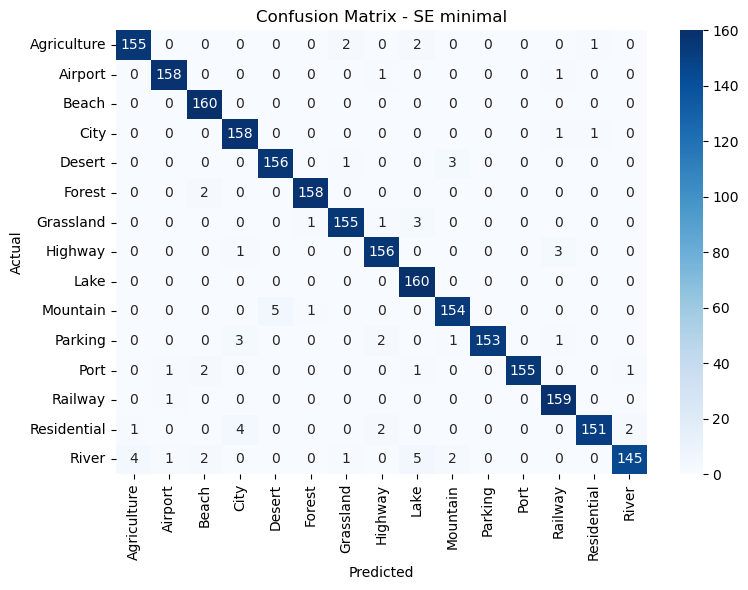


=== Running strategy with SE: default ===
Epoch 1/10 | Loss: 153.7053 | Train Acc: 0.7978 | Val Acc: 0.8804 | Val Loss: 29.0410
Epoch 2/10 | Loss: 59.7480 | Train Acc: 0.9176 | Val Acc: 0.8971 | Val Loss: 23.9196
Epoch 3/10 | Loss: 48.7556 | Train Acc: 0.9278 | Val Acc: 0.9171 | Val Loss: 20.3351
Epoch 4/10 | Loss: 39.5109 | Train Acc: 0.9425 | Val Acc: 0.9250 | Val Loss: 18.3935
Epoch 5/10 | Loss: 34.0118 | Train Acc: 0.9529 | Val Acc: 0.9221 | Val Loss: 18.1436
Epoch 6/10 | Loss: 23.0701 | Train Acc: 0.9667 | Val Acc: 0.9383 | Val Loss: 16.1427
Epoch 7/10 | Loss: 18.6996 | Train Acc: 0.9750 | Val Acc: 0.9463 | Val Loss: 14.0654
Epoch 8/10 | Loss: 17.2618 | Train Acc: 0.9754 | Val Acc: 0.9379 | Val Loss: 15.3466
Epoch 9/10 | Loss: 17.0486 | Train Acc: 0.9762 | Val Acc: 0.9400 | Val Loss: 14.7994
Epoch 10/10 | Loss: 14.7029 | Train Acc: 0.9789 | Val Acc: 0.9413 | Val Loss: 14.6584
Plotting training history...


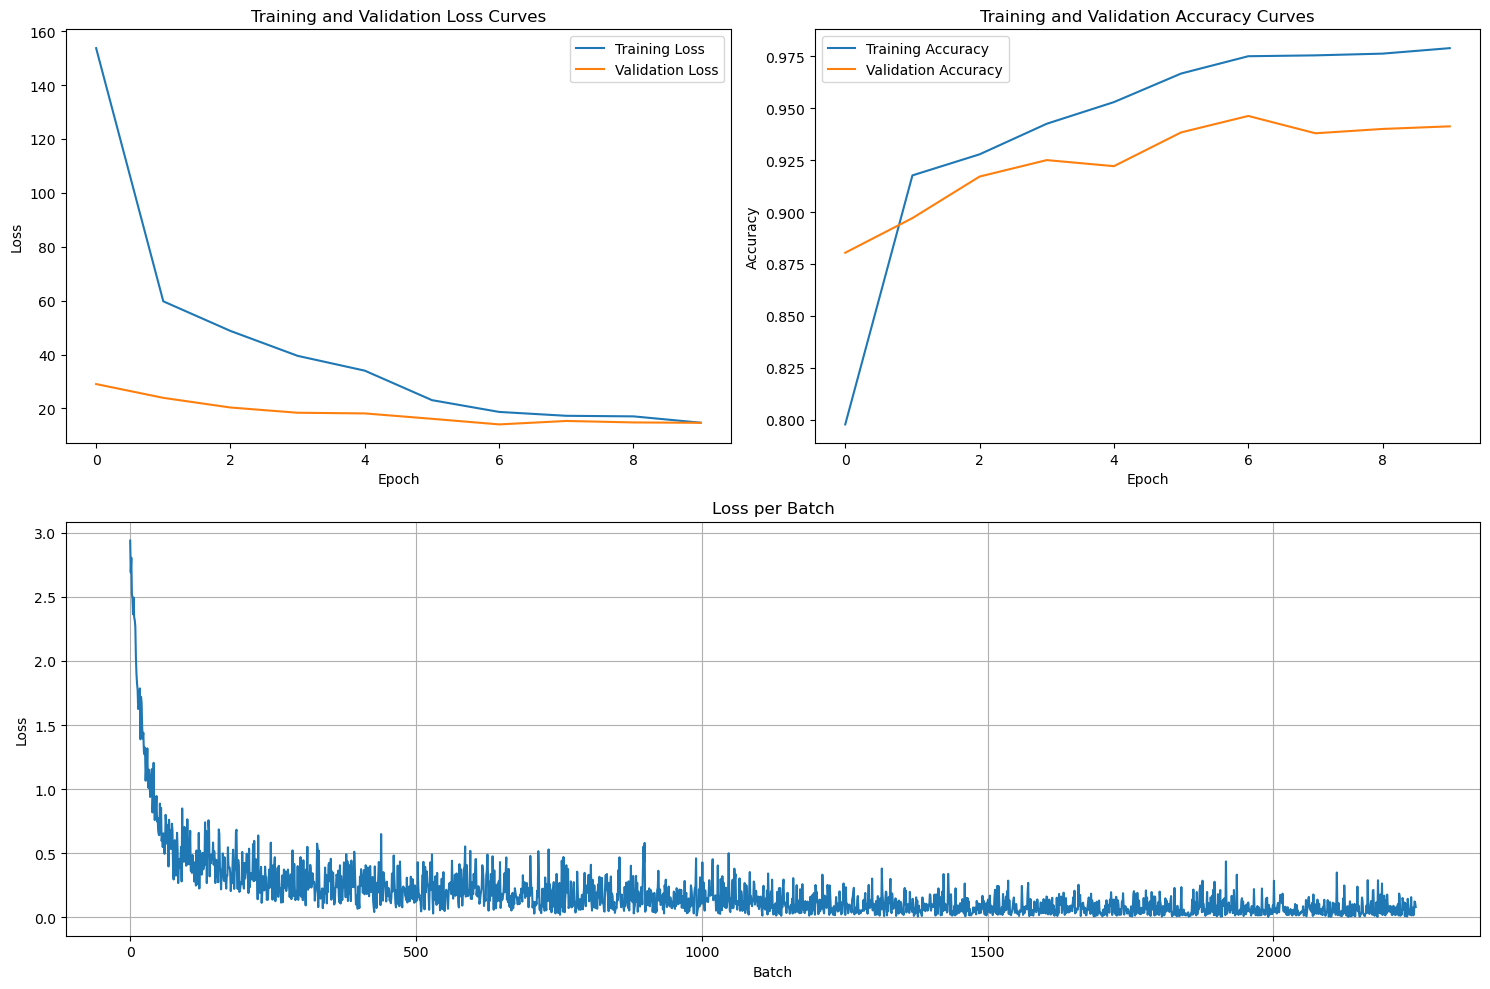

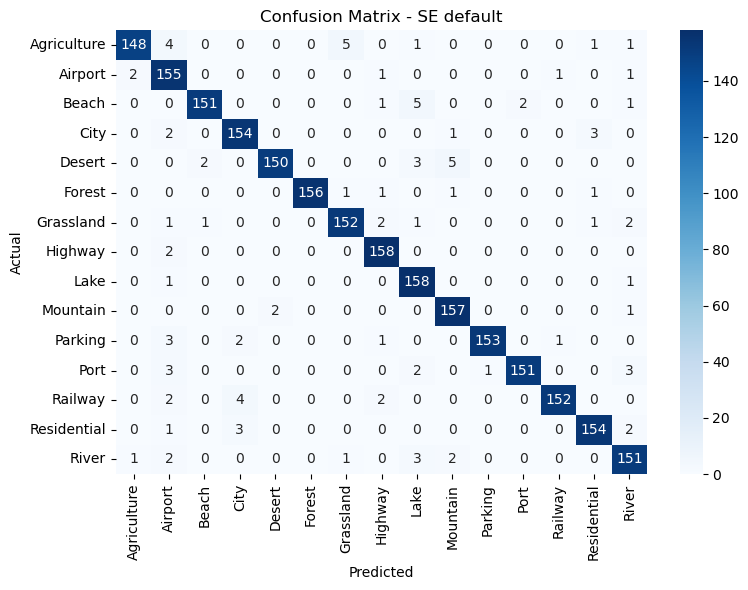


=== Running strategy with SE: extensive ===
Epoch 1/10 | Loss: 188.5670 | Train Acc: 0.7515 | Val Acc: 0.8246 | Val Loss: 42.6161
Epoch 2/10 | Loss: 91.1979 | Train Acc: 0.8729 | Val Acc: 0.8629 | Val Loss: 33.8586
Epoch 3/10 | Loss: 78.7866 | Train Acc: 0.8851 | Val Acc: 0.8496 | Val Loss: 37.7075
Epoch 4/10 | Loss: 64.8653 | Train Acc: 0.9075 | Val Acc: 0.8829 | Val Loss: 28.3904
Epoch 5/10 | Loss: 52.6462 | Train Acc: 0.9233 | Val Acc: 0.9054 | Val Loss: 24.2629
Epoch 6/10 | Loss: 44.4683 | Train Acc: 0.9407 | Val Acc: 0.9042 | Val Loss: 23.1155
Epoch 7/10 | Loss: 37.4546 | Train Acc: 0.9494 | Val Acc: 0.9067 | Val Loss: 22.7075
Epoch 8/10 | Loss: 39.0163 | Train Acc: 0.9458 | Val Acc: 0.8988 | Val Loss: 25.5262
Epoch 9/10 | Loss: 35.2173 | Train Acc: 0.9503 | Val Acc: 0.9171 | Val Loss: 20.8202
Epoch 10/10 | Loss: 32.0166 | Train Acc: 0.9536 | Val Acc: 0.9171 | Val Loss: 20.9909
Plotting training history...


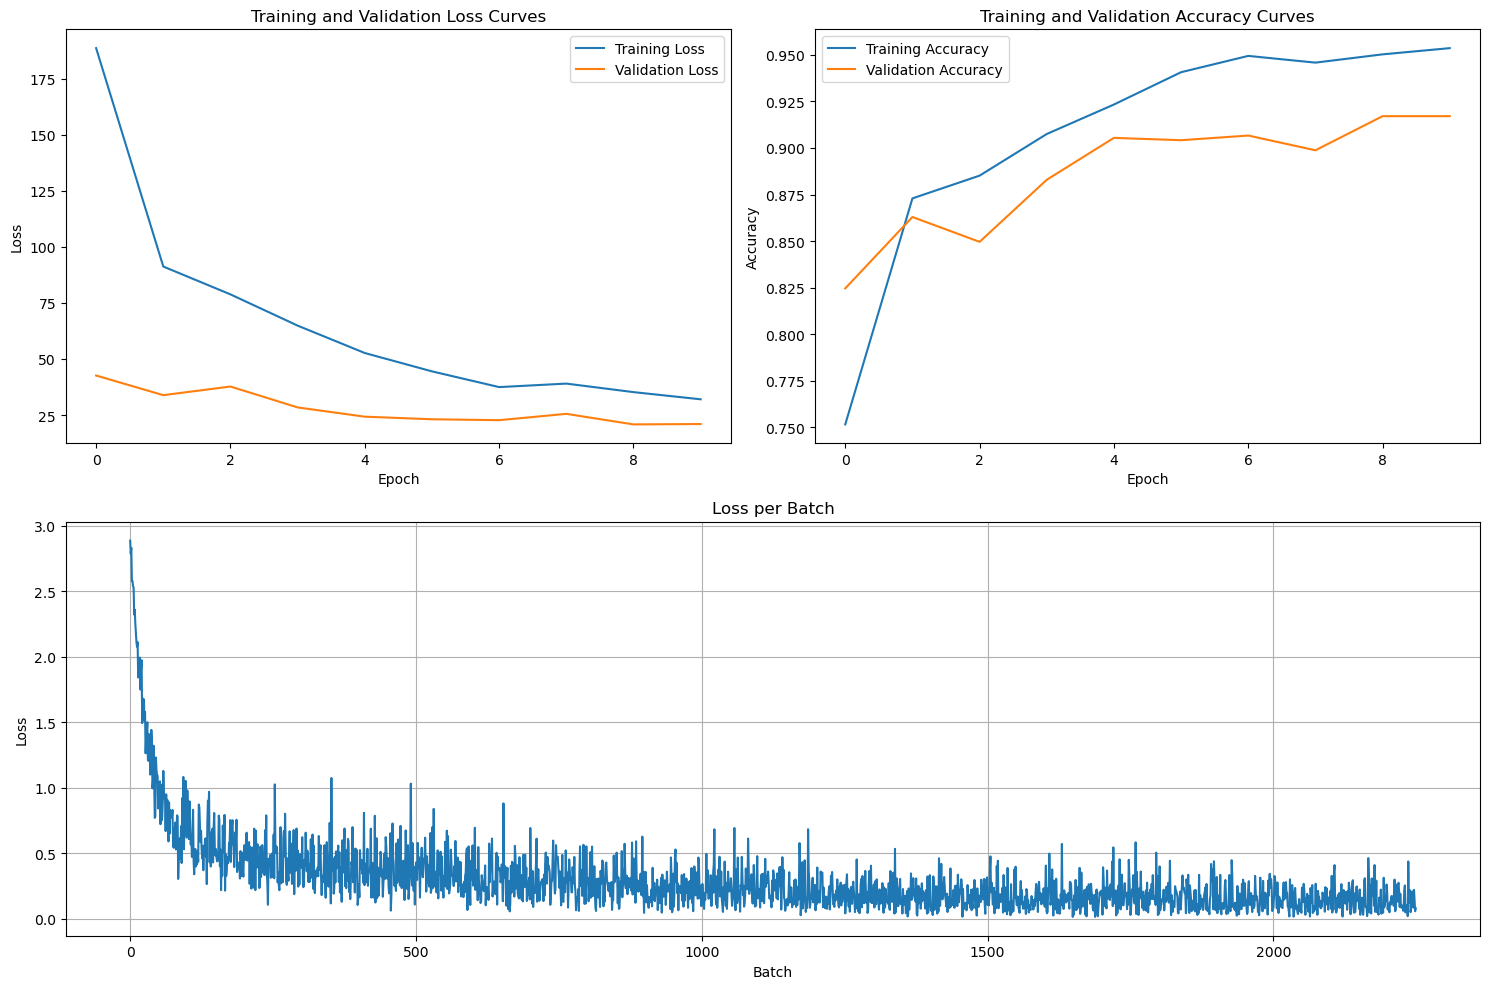

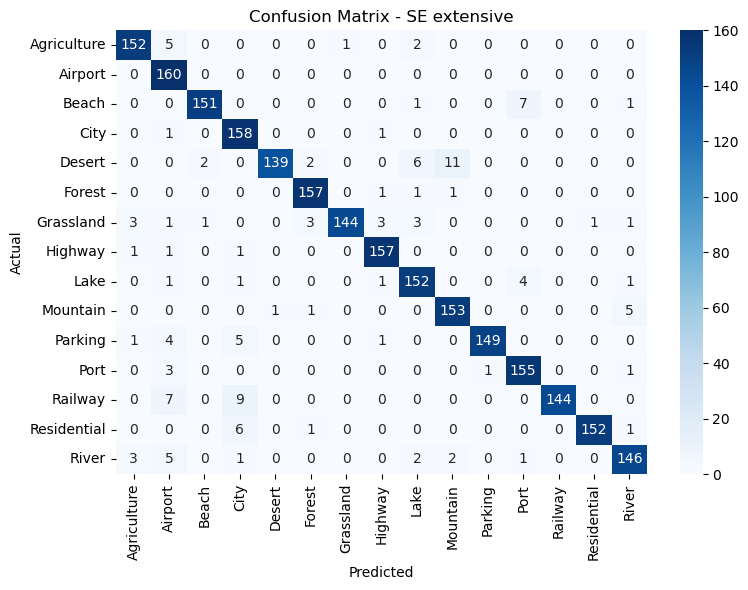

In [16]:
# Training and evaluation
strategies = ['minimal', 'default', 'extensive']
all_reports = []
all_class_names = None

for strategy in strategies:
    print(f"\n=== Running strategy with SE: {strategy} ===")

    train_loader, val_loader, test_loader, class_names = create_dataloaders(
        root_dir=os.path.abspath(os.path.join("..", "Aerial_Landscapes")),
        batch_size=32,
        augmentation_strategy=strategy,
        verbose=False
    )
    if all_class_names is None:
        all_class_names = class_names

    model = densenet121_se(num_classes=len(class_names)).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    best_val_acc = 0.0
    best_model_state = None
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'batch_losses': []}

    for epoch in range(10):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            history['batch_losses'].append(loss.item())
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        history['train_loss'].append(running_loss)
        history['train_acc'].append(train_acc)

        # Validation loss
        model.eval()
        val_loss = 0.0
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        print(f"Epoch {epoch+1}/10 | Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")
        scheduler.step()
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

    os.makedirs("saved_models_se", exist_ok=True)
    torch.save(best_model_state, f"saved_models_se/best_model_se_{strategy}.pth")
    model.load_state_dict(best_model_state)

    # Test evaluation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.numpy())

    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    all_reports.append((strategy, report))

    print("Plotting training history...")
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curves')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(range(len(history['batch_losses'])), history['batch_losses'])
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss per Batch')
    plt.grid(True)

    plt.tight_layout()
    os.makedirs("figures_se", exist_ok=True) 
    plt.savefig(f'figures_se/training_history_se_{strategy}.png')
    plt.show()

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - SE {strategy}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

In [17]:
# Format final table with MultiIndex columns
raw_metric_names = ['precision', 'recall', 'f1-score']
display_names = ['Precision', 'Recall', 'F1']
columns = pd.MultiIndex.from_product([strategies, display_names])
final_table = pd.DataFrame(index=all_class_names, columns=columns)

for strategy, report in all_reports:
    df = pd.DataFrame(report).transpose()
    df = df.loc[all_class_names]
    for raw, disp in zip(raw_metric_names, display_names):
        final_table[(strategy, disp)] = df[raw]

print("\nFinal comparison table with multi-index columns (center aligned):")
styled = final_table.style.set_table_styles([
    {"selector": "th", "props": [("text-align", "center")]},
    {"selector": "th.col_level0", "props": [("text-align", "center")]},
    {"selector": "th.col_level1", "props": [("text-align", "center")]},
    {"selector": "td", "props": [("text-align", "center")]}]).set_properties(**{'text-align': 'center'})
display(styled.format(precision=3))


Final comparison table with multi-index columns (center aligned):
